In [1]:
import sys
import os
import importlib

import numpy as np
import scipy
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt
from cycler import cycler

import pyemma
import mdtraj as md

import ivac
import extq
from extq.stop import forward_stop

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
feature_colors = ["grey", "#E46C0A", "#51BD52", "#D85BD8", "#5AA5A5", "#0000FF", "#ffcc00"]

In [4]:
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# distances to F161
rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy")[:115])
rf161_arr = np.concatenate(rf161)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0] # 0.1 ns lag time

In [6]:
# no c-alpha distances
X = np.hstack((cv_arr, sb_arr[:, 30:], rf161_arr))
y = np.concatenate(qp_du)
print(X.shape, y.shape)

(4150115, 35) (4150115,)


In [7]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

# LASSO

In [8]:
def run_lasso(data, q, alpha=0.1, fit_intercept=True):
    model = Lasso(alpha=alpha, fit_intercept=False)
    model.fit(data, q)
    recon = model.predict(data)
    beta = model.coef_
    intercept = model.intercept_
    score = model.score(data, q)
    return recon, beta, intercept, score

# Lasso down->TS and TS-> up

In [9]:
sb_ids = [42, 47, 52, 53, 58, 59]
X = np.hstack((cv_arr, sb_arr[:, sb_ids], rf161_arr[:, 1:2]))
y = np.concatenate(qp_du)
print(X.shape, y.shape)

(4150115, 9) (4150115,)


In [10]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

In [11]:
names = []
names.append(feature_names[0])
names.append(feature_names[1])
for i in sb_ids:
    names.append(feature_names[i - 30 + 2])
names.append(feature_names[33])

In [12]:
def sample_low(y, lo, hi, nsamp, w_arr):
    # take points at transition region
    low_idx = ((y > lo) & (y <= hi)).nonzero()[0]
    # weight by committor value
    low_weight = w_arr[low_idx] * y[low_idx] * (1 - y[low_idx])
    low_weight /= np.sum(low_weight)
    idx = np.random.choice(low_idx, size=min(nsamp,len(low_idx)), p=low_weight, replace=False)
    return idx

def sample_hi(y, lo, hi, nsamp, w_arr):
    hi_idx = ((y >= lo) & (y < hi)).nonzero()[0]
    # weight by committor value
    hi_weight = w_arr[hi_idx] * y[hi_idx] * (1 - y[hi_idx])
    hi_weight /= np.sum(hi_weight)
    idx = np.random.choice(hi_idx, size=min(nsamp,len(hi_idx)), p=hi_weight, replace=False)
    return idx

def transform_data_low(X, y, idx):
    # inverse sigmoid transform from (0, 0.5] -> (-inf, inf)
    logit_q = np.log(2 * y[idx] / (1 - 2 * y[idx]))
    # apply standardization
    std_scale = StandardScaler()
    X_trans = std_scale.fit_transform(X[idx])
    return X_trans, logit_q

def transform_data_hi(X, y, idx):
    # inverse sigmoid transform from [0.5, 1) -> (-inf, inf)
    logit_q = np.log((2 * y[idx] - 1) / (2 - 2 * y[idx]))
    # apply standardization
    std_scale = StandardScaler()
    X_trans = std_scale.fit_transform(X[idx])
    return X_trans, logit_q

In [13]:
nsamp = 100000
w_arr = np.concatenate(weights)
low_idx = sample_low(y, 0, 0.5, nsamp, w_arr)
hi_idx = sample_hi(y, 0.5, 1, nsamp, w_arr)
X_low, q_lo = transform_data_low(X, y, low_idx)
X_hi, q_hi = transform_data_hi(X, y, hi_idx)

In [14]:
coeffs_lo, coeffs_hi = [], []
r2_lo, r2_hi = [], []
alphas = np.linspace(0.01, 0.10, 10)
for a in alphas:
    print(f"Fitting alpha = {a:.2f}")
    _, coeffs, _, r2 = run_lasso(X_low, q_lo, alpha=a, fit_intercept=False)
    coeffs_lo.append(coeffs)
    r2_lo.append(r2)
    _, coeffs2, _, r22 = run_lasso(X_hi, q_hi, alpha=a, fit_intercept=False)
    coeffs_hi.append(coeffs2)
    r2_hi.append(r22)

Fitting alpha = 0.01
Fitting alpha = 0.02
Fitting alpha = 0.03
Fitting alpha = 0.04
Fitting alpha = 0.05
Fitting alpha = 0.06
Fitting alpha = 0.07
Fitting alpha = 0.08
Fitting alpha = 0.09
Fitting alpha = 0.10


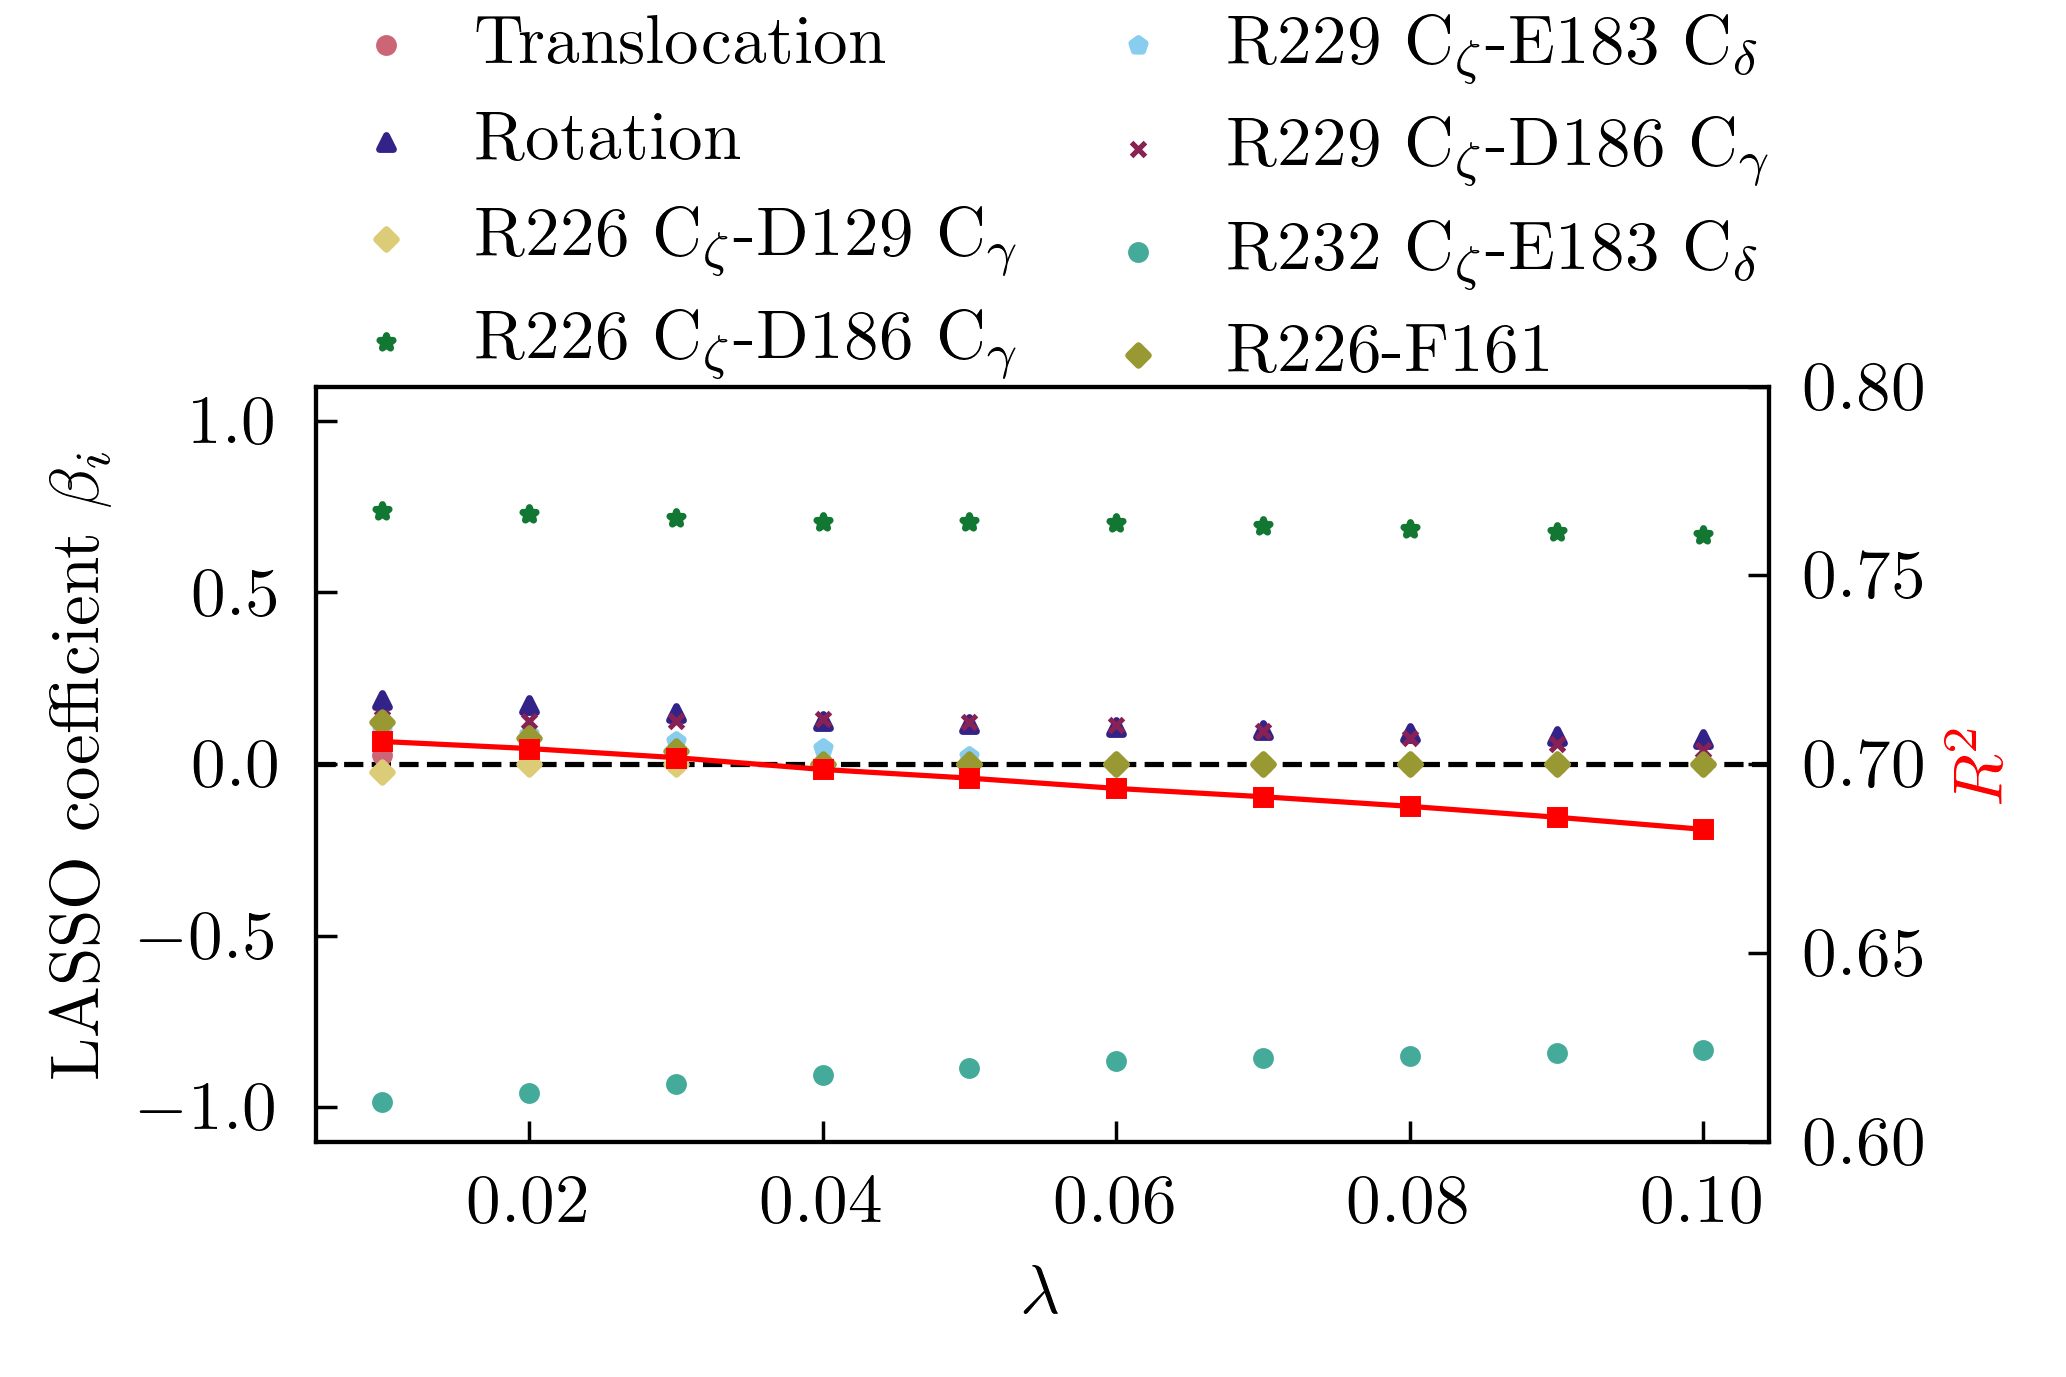

In [15]:
f = plt.figure(figsize=(3.75, 2), dpi=500)
ax = plt.gca()

ax2 = plt.twinx()

ax2.plot(alphas, r2_lo, '-s', color='r', zorder=1)
ax2.set_ylabel("$R^2$", color='r')
ax2.set_ylim([0.6, 0.8])

coeffs_lo = np.array(coeffs_lo)
markers = list('o^D*pxo^D*pxo')

for i in coeffs_lo[0].nonzero()[0]:
    ax.scatter(alphas, coeffs_lo[:, i], marker=markers[i], label=names[i])
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
ax.set_ylim([-1.1, 1.1])
ax.axhline(ls="--", color='black', zorder=0)
pplt.legend(ncol=2, outside='top', ax=ax, borderpad=-0.5, handletextpad=0.3, columnspacing=2.0)
plt.savefig("../../fig/paper/lasso_down_scan.pdf", bbox_inches='tight')

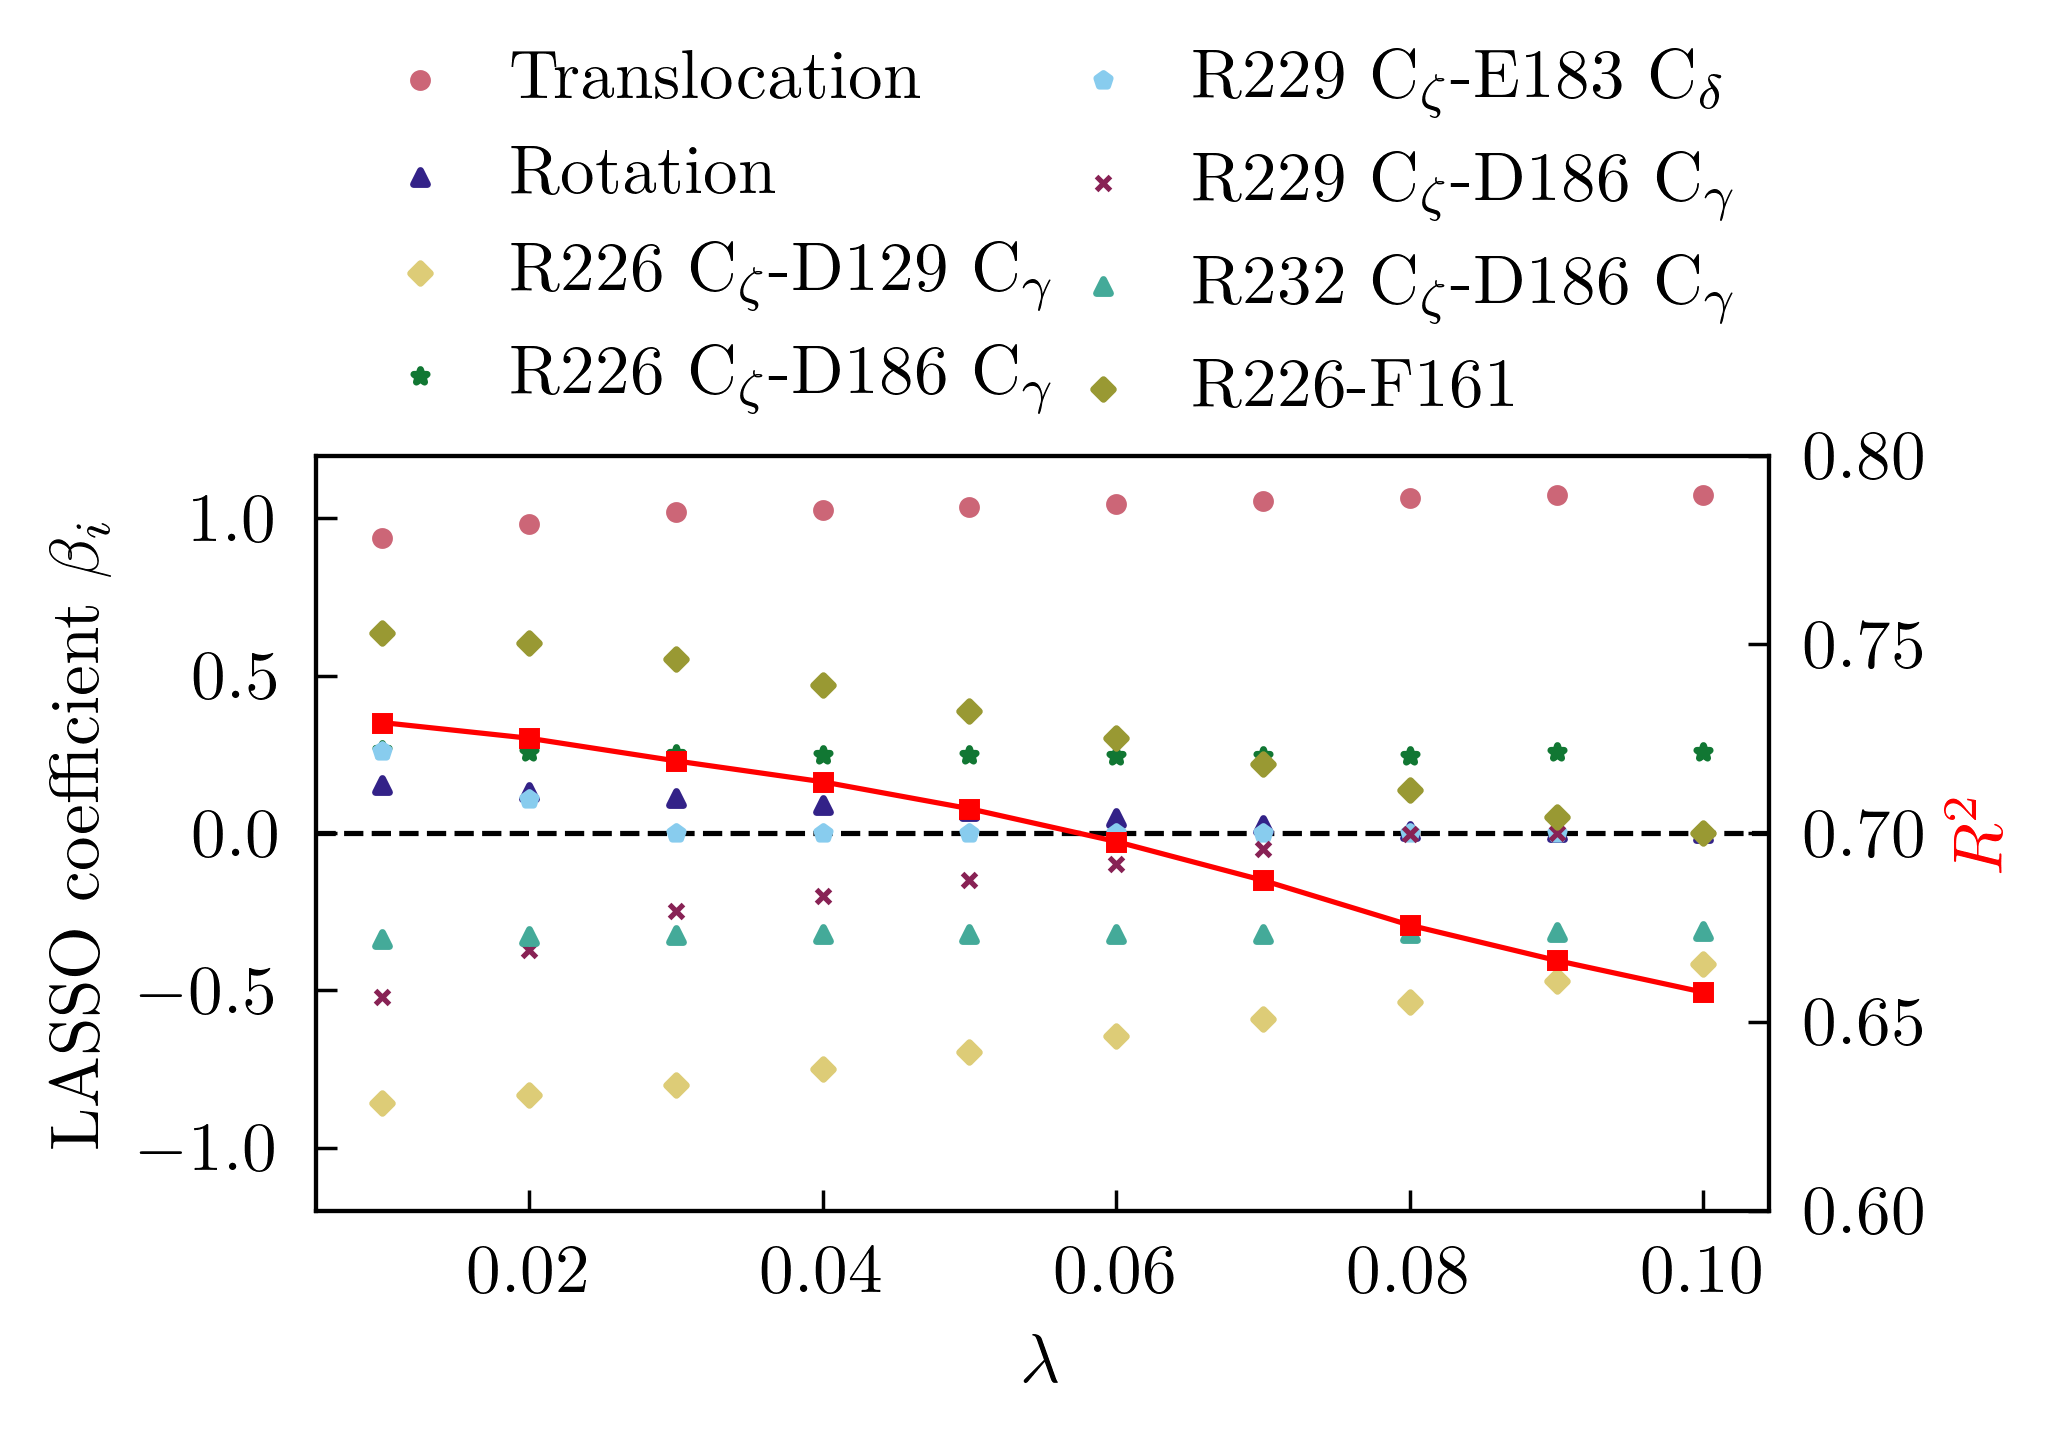

In [16]:
f = plt.figure(figsize=(3.75, 2), dpi=500)
ax = plt.gca()

ax2 = plt.twinx()

ax2.plot(alphas, r2_hi, '-s', color='r', zorder=1)
ax2.set_ylabel("$R^2$", color='r')
ax2.set_ylim([0.6, 0.8])

coeffs_hi = np.array(coeffs_hi)
markers = list('o^D*pxo^D*pxo')

for i in coeffs_hi[0].nonzero()[0]:
    ax.scatter(alphas, coeffs_hi[:, i], marker=markers[i], label=names[i])
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
ax.set_ylim([-1.2, 1.2])
ax.axhline(ls="--", color='black', zorder=0)
pplt.legend(ncol=2, outside='top', ax=ax, borderpad=0, handletextpad=0.3)
plt.savefig("../../fig/paper/lasso_up_scan.pdf", bbox_inches='tight')

<Figure size 1250x1250 with 0 Axes>

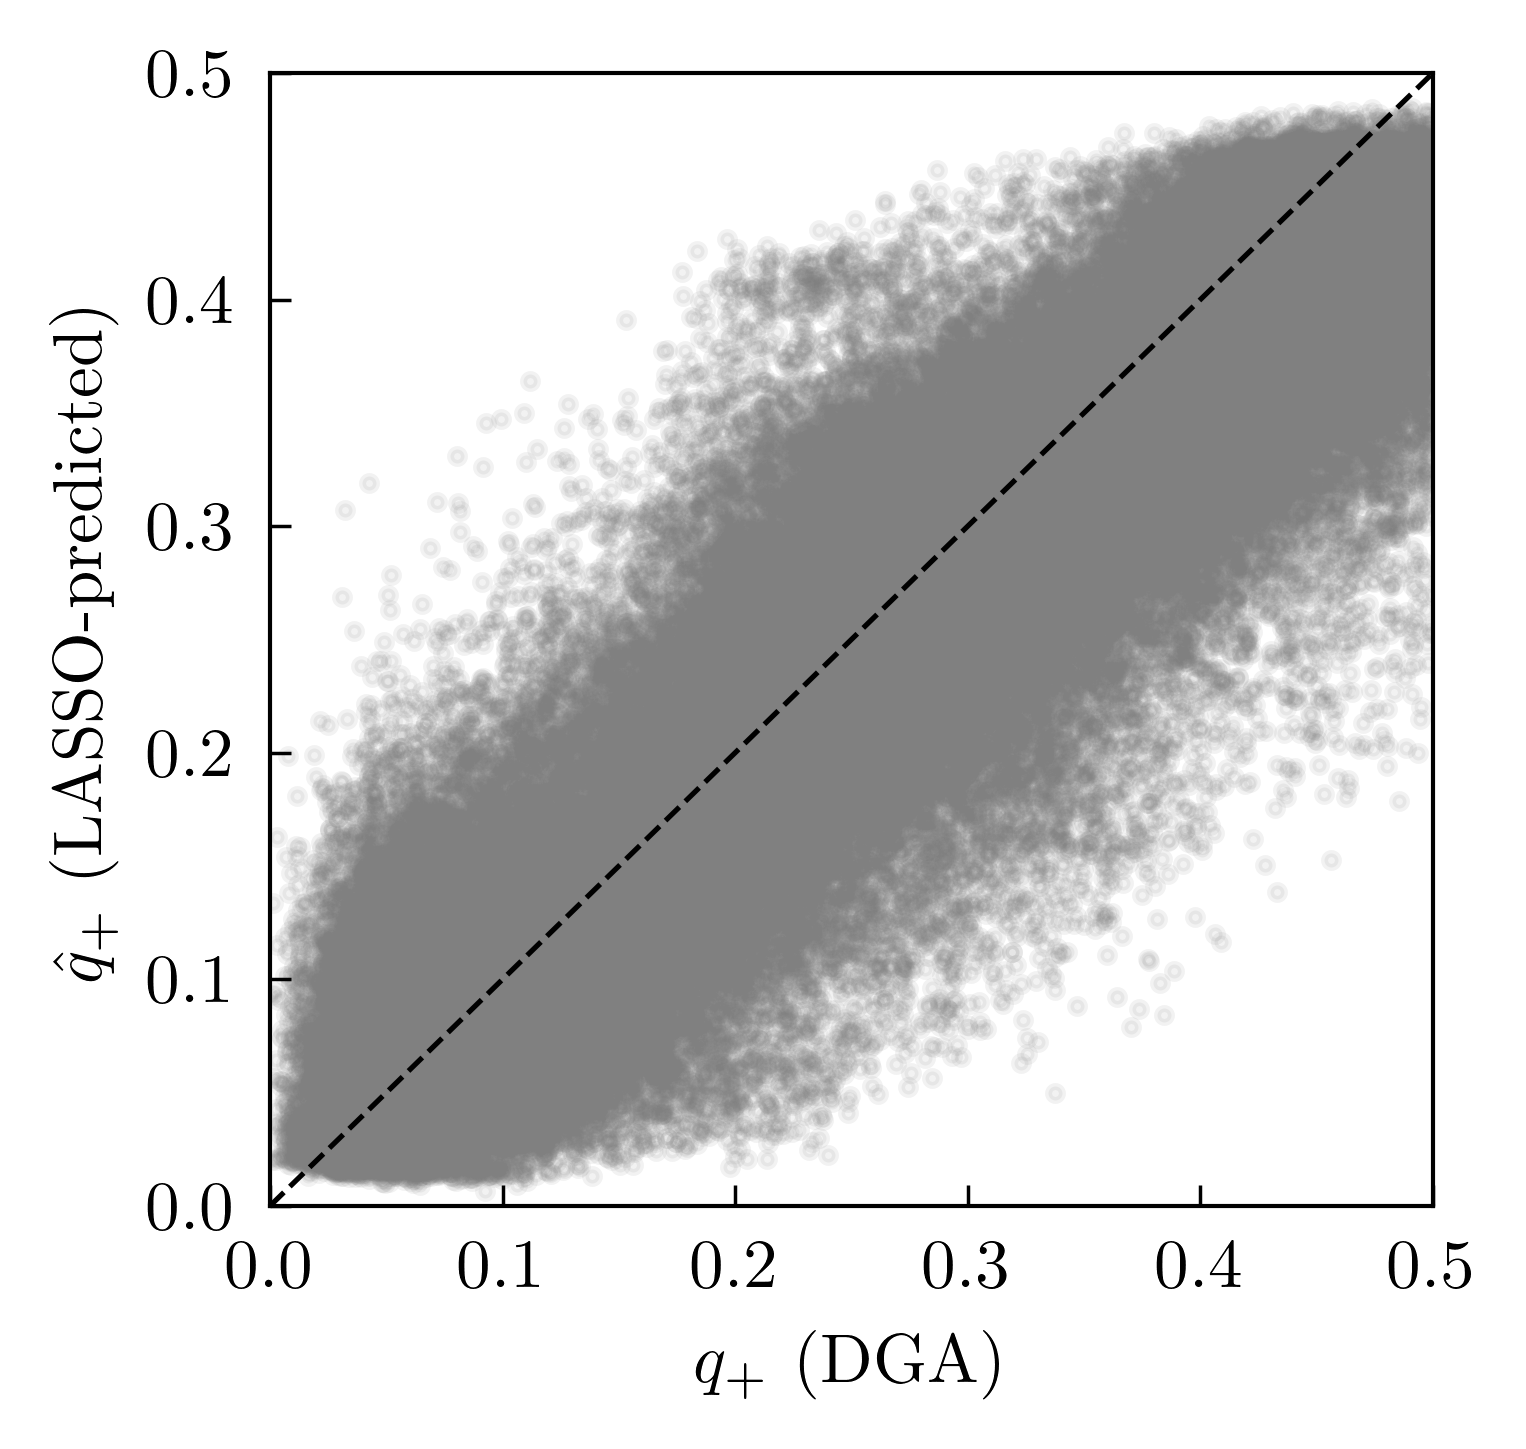

In [17]:
# plot correlation
plt.figure(figsize=(2.5, 2.5), dpi=500)
pred_logit = np.dot(X_low, coeffs_lo[1])
yhat = 0.5 / (1 + np.exp(-pred_logit))
f = plt.figure(figsize=(3., 3.), dpi=500)
ax = plt.gca()
ax.scatter(y[low_idx], yhat, alpha=0.1, c="gray", rasterized=True)
ax.plot(np.linspace(0., 0.5, 100), np.linspace(0., 0.5, 100), 'k--')
ax.set_xlim([0., 0.5])
ax.set_ylim([0., 0.5])
ax.set_xlabel("$q_+$ (DGA)")
ax.set_ylabel("$\hat{q}_+$ (LASSO-predicted)")
plt.savefig("../../fig/paper/lasso_down_corr.pdf", bbox_inches='tight')

<Figure size 1250x1250 with 0 Axes>

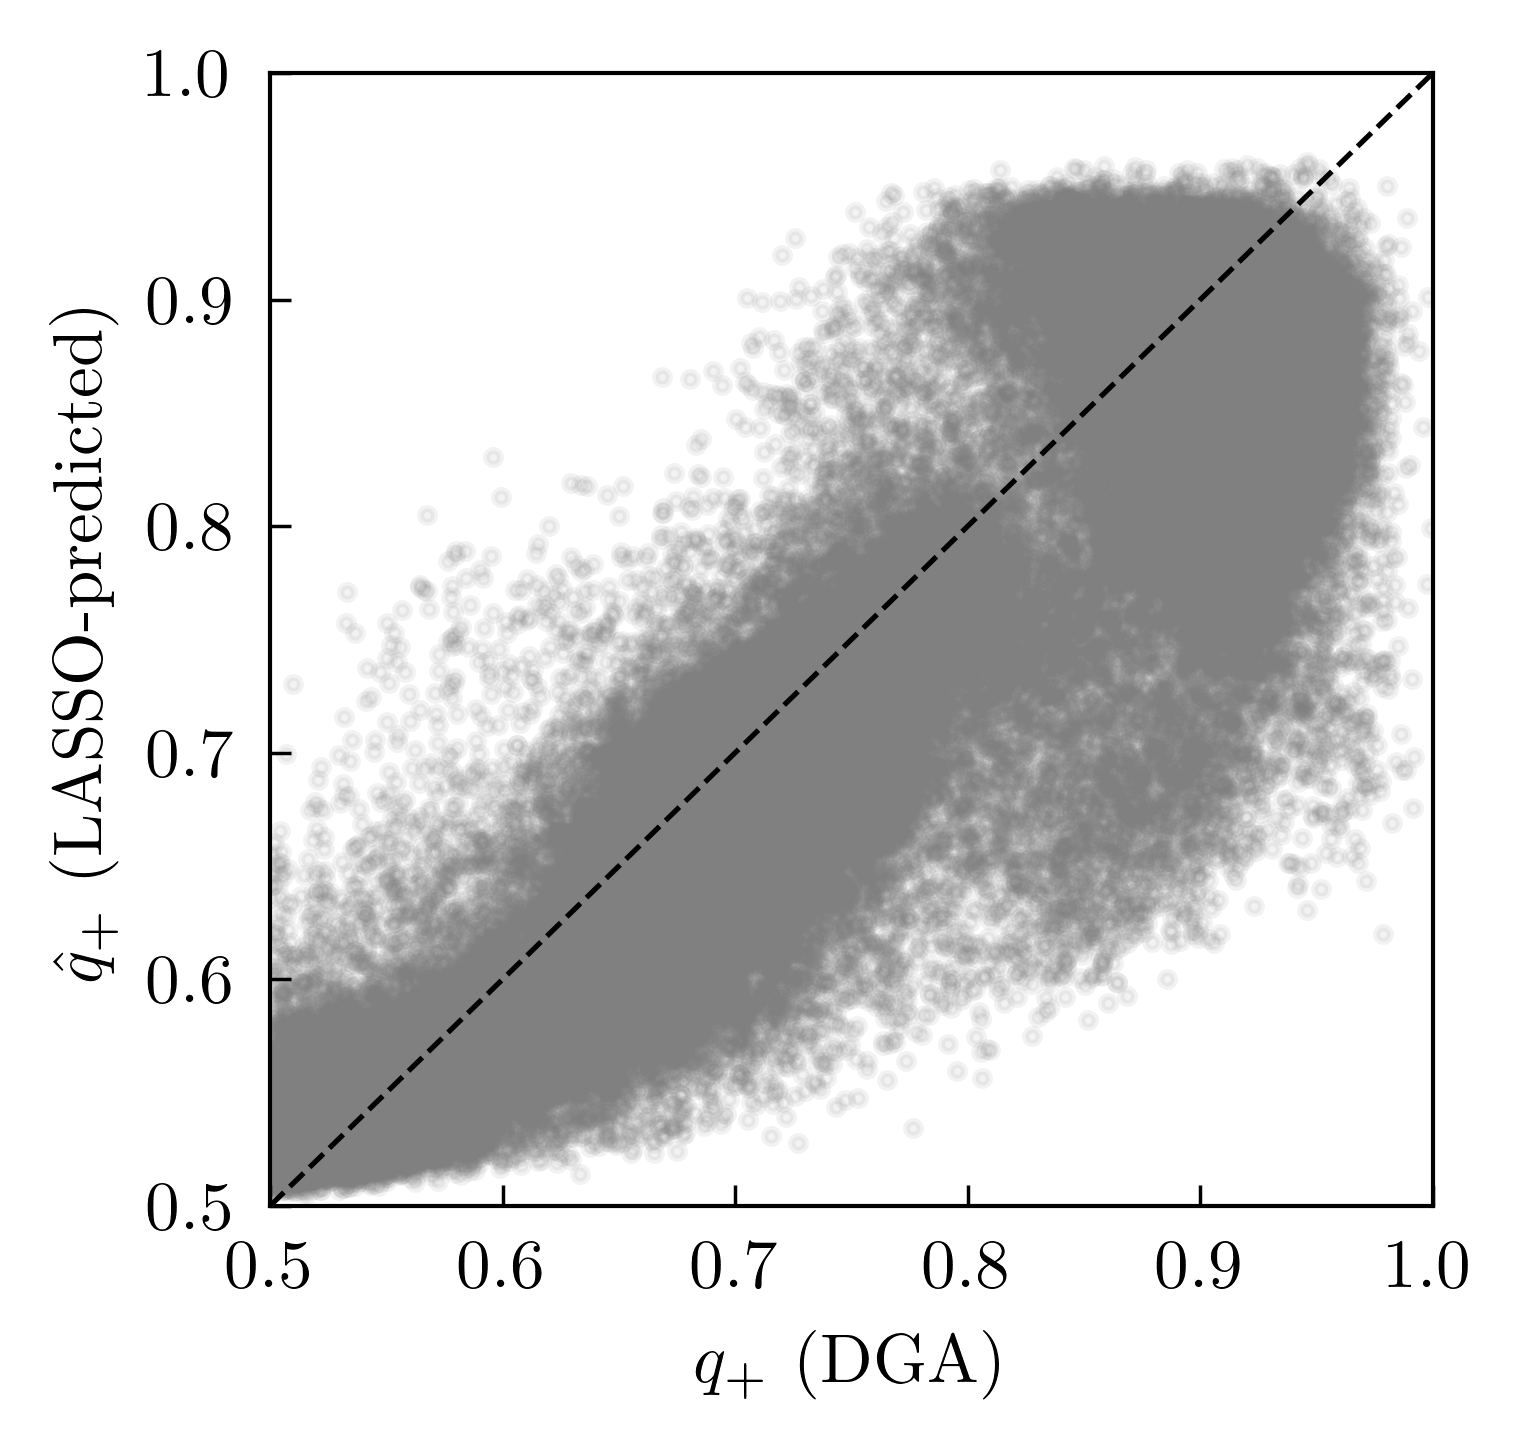

In [18]:
# plot correlation 
plt.figure(figsize=(2.5, 2.5), dpi=500)
pred_logit = np.dot(X_hi, coeffs_hi[2])
qhat = (2 * np.exp(pred_logit) + 1) / (2 + 2 * np.exp(pred_logit))
f = plt.figure(figsize=(3., 3.), dpi=500)
ax = plt.gca()
ax.scatter(y[hi_idx], qhat, alpha=0.1, c="gray", rasterized=True)
ax.plot(np.linspace(0.5, 1.0, 100), np.linspace(0.5, 1.0, 100), 'k--')
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0.5, 1.0])
ax.set_xlabel("$q_+$ (DGA)")
ax.set_ylabel("$\hat{q}_+$ (LASSO-predicted)")
plt.savefig("../../fig/paper/lasso_up_corr.pdf", bbox_inches='tight')

In [21]:
names = []
names.append(feature_names[0])
names.append(feature_names[1])
for i in sb_ids[:2]:
    names.append(feature_names[i - 30 + 2])
names.append(feature_names[33])
for i in sb_ids[2:]:
    names.append(feature_names[i - 30 + 2])

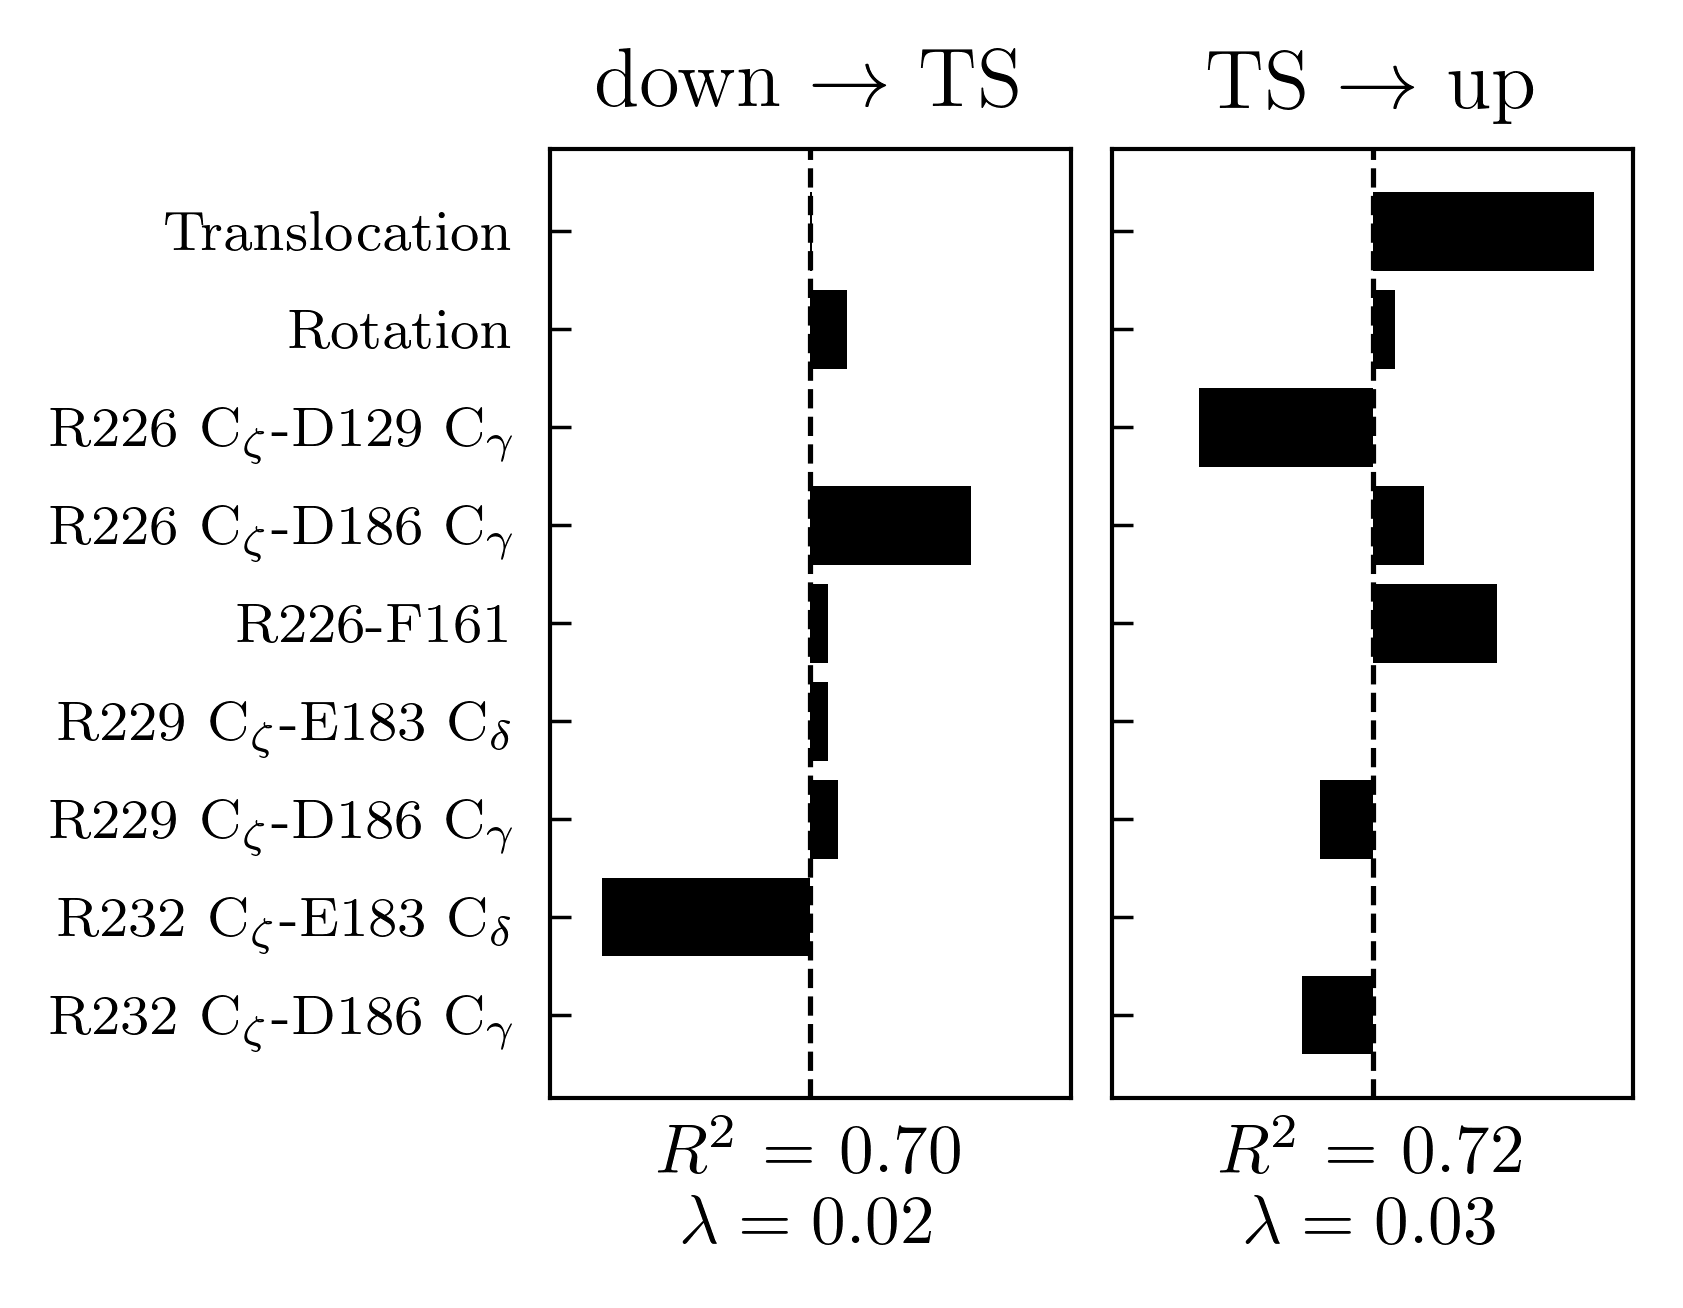

In [22]:
f, axs = plt.subplots(1, 2, figsize=(3.25, 2.5), dpi=500, constrained_layout=True, sharey=True, sharex=True)

for ax, c in zip(axs, (coeffs_lo[1], coeffs_hi[2])):
    # rearrange c so that R226-F161 comes after R226 features
    c_rearrange = [*c[:4], c[-1], *c[4:8]]
    ax.barh(np.arange(X.shape[-1]), c_rearrange, color='black', zorder=4)
    ax.axvline(color='black', zorder=0, ls='--')
    ax.set_xlim([-1.2, 1.2])
    ax.set_xticks([])
axs[0].set_yticks(ticks=np.arange(0, 9), labels=names, ha='right', fontsize=8)
# sns.despine(fig=f, top=True, left=False, right=True, bottom=False)
# axs[0].set_yticks(ticks=[])

# pplt.text(0.3, 0.95, f"$R^2$ = {r2_lo[1]:.2f}\n $\\lambda = {alphas[1]:.2f}$", ax=axs[0], transform=axs[0].transAxes, fontsize=8, bbox=dict(ec="black", fc="white"), zorder=5)
# pplt.text(0.3, 0.95, f"$R^2$ = {r2_hi[2]:.2f}\n $\\lambda = {alphas[2]:.2f}$", ax=axs[1], transform=axs[1].transAxes, fontsize=8, bbox=dict(ec="black", fc="white"), zorder=5)
axs[0].set_xlabel(f"$R^2$ = {r2_lo[1]:.2f}\n$\\lambda = {alphas[1]:.2f}$")
axs[1].set_xlabel(f"$R^2$ = {r2_hi[2]:.2f}\n$\\lambda = {alphas[2]:.2f}$")
axs[0].set_title(r"down $\rightarrow$ TS")
axs[1].set_title(r"TS $\rightarrow$ up")

axs[0].invert_yaxis()
plt.savefig("../../fig/paper/lasso_all_small_feature.pdf", bbox_inches='tight')